# Assignment 2


**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Summary**: Fact checking, Neural Languange Inference (**NLI**)

**Authors**: 

*   Davide Mercanti: davide.mercanti@studio.unibo.it
*   Riccardo Fava: riccardo.fava6@studio.unibo.it
*   Luca Bompani: luca.bompani4@studio.unibo.it

In [1]:
!pip install fasttext
!pip install multiprocess

     |████████████████████████████████| 68 kB 3.7 MB/s 
  Using cached pybind11-2.8.1-py2.py3-none-any.whl (208 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3121946 sha256=fa3ab8f7ed879f0144a9e0936862565e96e2c0b97eeccb6e863c82cf8abcf3f8
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [21]:
from google.colab import drive

drive.mount('/content/drive')

PATH = '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/drive/MyDrive/UniBO/NLP/Assignent_2/util.py .

In [3]:
from collections import defaultdict
from enum import Enum
import time, string

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 
import pandas as pd

from functools import reduce
import re,sys,os
import contextlib

from sklearn.metrics import f1_score, recall_score, precision_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from torch.nn.utils.rnn import pad_sequence
from torch import tensor
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn.functional import pad

import fasttext
import fasttext.util
import multiprocess as mp  # =! multiprocessing

from util import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


device(type='cuda')

In [4]:
import os
import requests
import zipfile

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data('dataset')

Download completed!
Extracting dataset...
Extraction completed!


## Dataset pre-processing

### Dataset loading and inspection

In [5]:
TRAIN_DF = pd.read_csv(f"dataset/train_pairs.csv")
TEST_DF  = pd.read_csv(f"dataset/test_pairs.csv")
VALID_DF = pd.read_csv(f"dataset/val_pairs.csv")

TRAIN_DF["Evidence"][4]

"10\tThe island 's geography comprises relatively low-lying mountains surrounding a central plain , with several navigable rivers extending inland .\tisland\tisland\tgeography\tgeography\tseveral navigable rivers\tRivers of Ireland"

In [6]:
try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    print('stopwords download')
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))


def preprocess_text(text):
    '''Applies a list of pre-processing functions in sequence (reduce).'''
    
    def remove_stopwords(sentence):
        return ' '.join([word for word in sentence.split() if word not in (STOPWORDS)])

    def lower(text) :
        return text.lower()

    def convert_round_brackets(text) :
        # convert -LRB- -RRB- to ( or )
        pattern = r'-LRB-'
        text = re.sub(pattern, '(', text)
        pattern = r'-RRB-'
        return re.sub(pattern, ')', text)

    def fix_double_dashes(text) :
        # fix: double dashes (--)
        pattern = r'\-\-'
        return re.sub(pattern, '-', text)

    def remove_leading_tabs(text) :
        # remove leading tabs
        pattern = r'[0-9]+?\t'
        return re.sub(pattern, '', text)

    def remove_pronunciations(text) :
        # remove pronunciations
        pattern = r'-LSB-.*?-RSB-(\s;)*?'
        return re.sub(pattern, '', text)

    def remove_trailing_tags(text):
        pattern=r'.\t.*?$'
        return re.sub(pattern, '', text)
    
    def trailing_tags(text):
        return re.sub('\t', ' ', text)

    def split_periods(text) :
        pattern = r'(\s.+?)\.'
        return re.sub(pattern, r'\1 .', text)

    def fix_days(text) :
        # fix: 31st -> 31 st
        pattern = r'([0-9]{1,2})(st|nd|rd|th)'
        return re.sub(pattern, r'\1', text)

    def separate_years(text) :
        # separate years from other words
        pattern = r'(\s.+?)([0-9]{4})'
        return re.sub(pattern, r'\1 \2', text) 

    def fix_years_ranges(text) :
        # fix years ranges
        pattern = r'([0-9]{4})\-([0-9]{4})'
        text = re.sub(pattern, r'\1 - \2', text)
        pattern = r'([0-9]{2})([0-9]{2})\-([0-9]{2})'
        text = re.sub(pattern, r'\1\2 - \1\3', text)
        pattern = r'\'([0-9]{2})-\'([0-9]{2})'
        return re.sub(pattern, r'19\1 - 19\2', text)

    def fix_number_ranges(text) :
        # fix: numbers ranges
        pattern = r'([0-9]+?[,\.][0-9]+?)+?-([0-9]+?[,\.][0-9]+?)+'
        return re.sub(pattern, r'\1 - \2', text)

    def fix_double_tick(text) :
        # fix: double tick
        pattern = r'\`\`'
        return re.sub(pattern, '"', text)

    def fix_date_merged(text) :
        # fix: year/day merged with other word
        pattern = r'([0-9]{1,4})([a-zA-Z]+?)'
        return re.sub(pattern, r'\1 \2', text)

    def remove_round_brackets(text) :
        # remove between round brackets
        pattern = r'\([^\(\)]+?\)'
        return re.sub(pattern, ' ', text)

    def remove_double_spaces(text) :
        # remove double spaces
        pattern = r'(\s)\s+?'
        return re.sub(pattern, r'\1', text)
    
    preprocessing_pipeline = [
                          remove_leading_tabs,
                          #remove_trailing_tags,
                          trailing_tags,
                          remove_stopwords,
                          convert_round_brackets,
                          #remove_round_brackets,
                          remove_pronunciations,
                          fix_double_dashes,
                          split_periods,
                          fix_days,
                          separate_years,
                          fix_years_ranges,
                          fix_number_ranges,
                          fix_double_tick,
                          fix_date_merged,
                          remove_double_spaces,
                          lower]
    
    return reduce(lambda txt, f: f(txt), preprocessing_pipeline, text)

stopwords download
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
print('Sentence before the cleaning:')
print(''.join(TRAIN_DF['Evidence'][0]))
print('')

def ser_prepr(ser, fun):
    return ser.apply(fun)

def per_column_parallel_apply(df, fun, cols, maxpr=4):
    pool = mp.Pool(processes=min(df.shape[1], maxpr))
    wait_g = [pool.apply_async(ser_prepr, args=(df[col], fun)) for col in df.columns[cols]]
    print(f'launched {len(wait_g)} processes')
    wait_g = iter(wait_g)
    return pd.DataFrame({
        df.columns[i]: (next(wait_g).get() if i in cols else df.iloc[:,i]) for i in range(df.shape[1])
    })

TRAIN_DF = per_column_parallel_apply(TRAIN_DF, preprocess_text, [1,2])

print('Sentence after the cleaning:')
print(TRAIN_DF['Evidence'][0])


Sentence before the cleaning:
2	Hemsworth has also appeared in the science fiction action film Star Trek -LRB- 2009 -RRB- , the thriller adventure A Perfect Getaway -LRB- 2009 -RRB- , the horror comedy The Cabin in the Woods -LRB- 2012 -RRB- , the dark-fantasy action film Snow White and the Huntsman -LRB- 2012 -RRB- , the war film Red Dawn -LRB- 2012 -RRB- , and the biographical sports drama film Rush -LRB- 2013 -RRB- .	Star Trek	Star Trek (film)	A Perfect Getaway	A Perfect Getaway	The Cabin in the Woods	The Cabin in the Woods	Snow White and the Huntsman	Snow White and the Huntsman	Red Dawn	Red Dawn (2012 film)	Rush	Rush (2013 film)

launched 2 processes
Sentence after the cleaning:
hemsworth also appeared science fiction action film star trek ( 2009 ) , thriller adventure a perfect getaway ( 2009 ) , horror comedy the cabin woods ( 2012 ) , dark-fantasy action film snow white huntsman ( 2012 ) , war film red dawn ( 2012 ) , biographical sports drama film rush ( 2013 ) . star trek star

In [8]:
VALID_DF = per_column_parallel_apply(VALID_DF, preprocess_text, [1,2])

launched 2 processes


In [9]:
TEST_DF = per_column_parallel_apply(TEST_DF, preprocess_text, [1,2])

launched 2 processes


## Fasttext embedding model

In [10]:
def update_corpus_file(dataframe):
    global PATH
    f = open(PATH + "data.txt", "w")
    for i in range(len(dataframe)):
        f.write(dataframe['Evidence'][i] + os.linesep)
        f.write(dataframe['Claim'][i] + os.linesep )
    f.close()

In [22]:
fasttext.FastText.eprint = lambda x: None

try:
    MODEL = fasttext.load_model(PATH + "embedding_model.bin")
except ValueError as e:
    print(e)
    update_corpus_file(TRAIN_DF)
    MODEL = fasttext.train_unsupervised(PATH +'data.txt', model='skipgram', minCount=1, dim=200)
    MODEL.save_model(PATH + "embedding_model.bin")

### Building embedding matrix

In [84]:
EMBEDDING_DIM = 200
WORD_TO_POSITION_DICTIONARY = {}

for i,word in enumerate(MODEL.words):
    WORD_TO_POSITION_DICTIONARY[word] = i+1
    
WEIGHT_MATRIX=np.array([0 for i in range(EMBEDDING_DIM)]).reshape(1,-1)    
WEIGHT_MATRIX = np.concatenate((WEIGHT_MATRIX,np.array([MODEL.get_word_vector(i) for i in WORD_TO_POSITION_DICTIONARY])))

print(f'Weights matrix size: {WEIGHT_MATRIX.shape}')
print(f'Word_to_position_dictionary size: {len(WORD_TO_POSITION_DICTIONARY)}')

Weights matrix size: (40497, 200)
Word_to_position_dictionary size: 40496


In [85]:
WORD_TO_POSITION_DD = autoIntDict(dict(WORD_TO_POSITION_DICTIONARY))

## Data conversion and data iterators

In [82]:
def update_embed_matrix(df, new_words):
    ''' Updates WEIGHT_MATRIX inplace by adding it the vectors predicted 
    by the FastText model (appending them to the 1st dimension.) '''
    global WEIGHT_MATRIX, MODEL

    for word in new_words:
        new_embedding = MODEL.get_word_vector(word)
        WEIGHT_MATRIX = np.concatenate((WEIGHT_MATRIX, new_embedding.reshape((1,len(WEIGHT_MATRIX[0])))))
        
    print(f'Weights matrix size: {WEIGHT_MATRIX.shape}')
        

def apply_conversion(df, word_to_pos_dd):
    '''Encodes a dataframe by applying an incremental encoding to the 1st column (specified
    by one_hot_dictionary) and a one-hot encoding to the 2nd: '''
    global WEIGHT_MATRIX
  
    max_pad_len = df.iloc[:,2].apply(len).max()
                
    col1 = df['Evidence'].apply(lambda _: [word_to_pos_dd[l]  for l in word_tokenize(_) ])
    col2 = df['Claim'].apply(lambda _: [word_to_pos_dd[l]  for l in word_tokenize(_) ])
    dic = { 'SUPPORTS':tensor([0,1]), 'REFUTES':tensor([1,0]) }
    col3 = df['Label'].apply(lambda x:dic[x])
        
    encoded_df = pd.DataFrame(zip(col1,col2,col3,df['ID']), columns=['Evidence','Claim','Label','ID'])
        
    update_embed_matrix(df, word_to_pos_dd.get_newly_added())
          
    return encoded_df

### Data conversion

In [86]:
ENCODED_TRAIN_DF = apply_conversion(TRAIN_DF, WORD_TO_POSITION_DD) 
ENCODED_VALID_DF = apply_conversion(VALID_DF, WORD_TO_POSITION_DD)

ENCODED_TRAIN_DF.head(5)


Weights matrix size: (40718, 200)
Weights matrix size: (42434, 200)


,Evidence,Claim,Label,ID
0,"[1897, 45, 151, 60, 52, 92, 7, 108, 727, 4, 14...","[251, 1897, 151, 32, 723, 4764, 2]","[tensor(0), tensor(1)]",3
1,"[5018, 4475, 4, 1, 33, 370, 146, 6436, 28, 431...","[5018, 4475, 200, 2]","[tensor(0), tensor(1)]",7
2,"[5018, 4475, 4, 1, 33, 370, 146, 6436, 28, 431...","[5018, 4475, 606, 2]","[tensor(1), tensor(0)]",8
3,"[5, 172, 17, 2881, 5784, 7064, 19254, 1795, 61...","[476, 7064, 19254, 1795, 2]","[tensor(0), tensor(1)]",9
4,"[5, 172, 17, 2881, 5784, 7064, 19254, 1795, 61...","[476, 7064, 19254, 1795, 2]","[tensor(1), tensor(0)]",10


### Data iterators

In [27]:
BATCH_SIZE = 128
EVID_PAD_LENGTH=0
CLAIM_PAD_LENGTH=0
datasets = [CustomTextDataset(_) for _ in (ENCODED_TRAIN_DF, ENCODED_VALID_DF)]  

train_dataset, val_dataset = datasets  

def Define_padding(type="local",method=np.max):
    """return the collate fn based on the parameter if local the function simply pad the batch to the max lenght in the batch else it uses method to calculate the padding lenght """
    global ENCODED_TRAIN_DF, EVID_PAD_LENGTH, CLAIM_PAD_LENGTH
    EVID_PAD_LENGTH=method(ENCODED_TRAIN_DF['Evidence'].apply(lambda x:len(x)))
    CLAIM_PAD_LENGTH=method(ENCODED_TRAIN_DF['Claim'].apply(lambda x:len(x)))

    def padding(list_tensors,lenght,batch_first=True, padding_value=0):
        """returns a tensor which is the concatenation of all the tensors in the list (all padded to the same lenght) """
        sizes= [i.size()[-1] for i in list_tensors]
        to_cat=[pad(list_tensors[i],(0,lenght-sizes[i]),value = padding_value) for i in range(len(sizes))]
        return torch.stack(to_cat,dim=0)

    def collate_fn(batch):
        global DEVICE
        labels = torch.from_numpy(np.array([i[2].numpy() for i in batch],dtype=int))
        texts = [torch.from_numpy(np.array(i[1], dtype=int)) for i in batch]
        evidences = [torch.from_numpy(np.array(i[0],dtype=int))  for i in batch]
        #Applying padding
        if(type=="local"):
            texts = pad_sequence(texts, batch_first=True, padding_value=0)
            evidences = pad_sequence(evidences, batch_first=True, padding_value=0)
        elif(type == "global"):
            texts=padding(texts,CLAIM_PAD_LENGTH)
            evidences = padding(evidences,EVID_PAD_LENGTH)
        return (labels.to(DEVICE), evidences.to(DEVICE), texts.to(DEVICE))
    
    return collate_fn 
  

train_dataloader, val_dataloader = \
  (DataLoader(_, batch_size=BATCH_SIZE, shuffle=False, collate_fn=Define_padding()) for _ in datasets)

## Functions for the training

### Training functions

In [12]:
def train(dataloader, model, optimizer, epoch=None, criterion=torch.nn.CrossEntropyLoss(), verbose=True, log_interval=300):
    model.train()
    total_acc, total_count = 0, 0
    start_time = time.time()
    losses = []
    
    for idx, (label, evidence, text) in enumerate(dataloader):
        optimizer.zero_grad() 
        predicted_label = model(text, evidence)  
        loss = criterion(predicted_label, label.argmax(1))
        loss.backward()                                          
        losses.append(loss.item())       
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        model.embedding.weight.grad[tensor(0)] = 0 
        optimizer.step()
        total_acc += (predicted_label.argmax(1)==label.argmax(1)).sum().item()
        total_count += label.size()[0]                         
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            if verbose:
                print(f'| epoch {(epoch if epoch else 0):3d} | {idx:5d}/{len(dataloader):5d} batches |' 
                      + f' accuracy { total_acc/total_count:8.3f}| loss {losses[-1]:.5f}')
            total_acc, total_count = 0, 0
            start_time = time.time()
            
    return losses, total_acc/total_count

def evaluate(dataloader, model, criterion=torch.nn.CrossEntropyLoss(), retain=False):
    ''' Evaluates 'model' over the dataloader.
      Returns the history of the loss values and the tag-level accuracy.
    '''
    model.eval()
    accumulated_good_pred, total_count = 0, 0
    val_steps = 0.0, 0
    accumulated_loss, history = [], []
    with torch.no_grad():
        for idx, (label,evidence, text) in enumerate(dataloader):
            predicted_label = model(text, evidence) 
            loss = criterion(predicted_label, label.argmax(1)) 
            accumulated_good_pred += (predicted_label.argmax(1)==label.argmax(1)).sum().item()
            total_count += label.size()[0]
            accumulated_loss.append(loss.item())
            if retain:
                y_true = label.argmax(1).cpu().numpy()
                y_pred = predicted_label.argmax(1).cpu().numpy()
                history += zip(y_true, y_pred)
    return accumulated_loss, accumulated_good_pred/total_count, history

### Training Loop

In [13]:
def get_f1_score(hist):
    y_true, y_pred = zip(*hist)
    return f1_score(y_true, y_pred, average='macro')

def get_recall_score(hist):
    y_true, y_pred = zip(*hist)
    return recall_score(y_true, y_pred, average='macro')

def get_precision(hist):
    y_true, y_pred = zip(*hist)
    return precision_score(y_true, y_pred, average='macro')

In [14]:
def train_loop(
    create_model,
    train_dataloader,
    val_dataloader,
    params = {'hidden': 256, 'LR_Adam': 0.0001},
    criterion = torch.nn.CrossEntropyLoss(),
    scheduler_ = torch.optim.lr_scheduler.StepLR,
    create_optimizer = 'default',
    scheduler_parr = {'step_size': 8, 'gamma':.1},
    epochs = 20,
    early_stop_patience = 4,
    verbose = False,
    log_interval=300,
    return_last_checkpoint = False
):
    global train, evaluate,DEVICE
    highlight = lambda _:f'{"-"*(len(_)+4)}\n  {_}\n{"-"*(len(_)+4)}'
    try:
        model = create_model(hidden=params['hidden']).to(DEVICE)
        if create_optimizer=='default':
            create_optimizer = lambda model_pars: torch.optim.Adam(model_pars, lr=params['LR_Adam'])
        optimizer = create_optimizer(model.parameters())
        scheduler = scheduler_(optimizer = optimizer, **scheduler_parr)
        total_accu = None
        last_loss = 100
        trigger_times = 0
        metrics = {'train_loss': [],
                  'val_loss': [],
                  'train_loss_hist': [],
                  'train_acc': [],
                  'val_acc': [],
                  'f1_score': 0,
                   'recall':0}

        for epoch in range(1, epochs + 1):
            epoch_start_time = time.time()
            losses_train, accu_train = train(train_dataloader, model, optimizer,
              verbose=verbose, criterion=criterion, epoch=epoch,
              log_interval=log_interval)
            loss_vals, accu_val, hist = evaluate(val_dataloader, model, criterion=criterion, retain=True)
            current_val_loss = np.mean(loss_vals)

            metrics['train_loss'].append(np.mean(losses_train))
            metrics['val_loss'].append(current_val_loss)
            metrics['train_loss_hist'].append(losses_train)
            metrics['train_acc'].append(accu_train)
            metrics['val_acc'].append(accu_val)
            

            if total_accu is not None and total_accu > accu_val:
                scheduler.step()
            else: total_accu = accu_val
            if verbose:
                print(highlight(f'| end of epoch {epoch:3d} | time: {time.time() - epoch_start_time:5.2f}s | '
                f'valid accuracy {accu_val:8.3f} | valid loss:{current_val_loss:8.3f}'))
            else:
                print(end=f"\rDoing epoch: {epoch:2}", flush=True)
          
            #Early stopping
            if current_val_loss > last_loss:
                trigger_times += 1
                if trigger_times >= early_stop_patience:
                    print("\n === Early Stopping ===\n")
                    metrics['f1_score'] = get_f1_score(hist)
                    metrics['recall'] = get_recall_score(hist)
                    print("\rVal_accuracy: ", accu_val, ' - F1-score: ', metrics['f1_score'],' - Recall:', metrics['recall'])
                    break
            else:  trigger_times = 0
            last_loss = current_val_loss

        if epoch==epochs:
            metrics['f1_score'] = get_f1_score(hist)
            metrics['recall'] = get_recall_score(hist)
            print("\rVal_accuracy: ", accu_val, ' - F1-score: ', metrics['f1_score'],' - Recall:', metrics['recall'])
        print()
        
    except Exception: raise
    else: return model, metrics
    finally:
        if return_last_checkpoint:
            cp = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}
            return model, metrics, cp

### Print plots function

In [15]:
def print_plots(metrics, complete_loss=False, size=(20,7)):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(*size)

    ax1.plot(metrics['train_loss'], '.-')
    ax1.plot(metrics['val_loss'], '.-')
    ax1.grid(True)
    if complete_loss:
        ax1.plot(metrics['train_loss_hist'], '.')
        ax1.set_ylim(0, np.max(metrics['train_loss_hist'])*1.1)
    else:
        ax1.set_ylim(0, np.max(metrics['val_loss']+metrics['train_loss'])*1.1)
    ax1.set_title('model loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epochs')
    ax1.set_xticks(range(len(metrics['train_loss'])))
    leg_lab = ['train_loss', 'val_loss']
    ax1.legend(leg_lab + ['train_complete_loss'] if complete_loss else leg_lab,
               loc='upper right')
    m1, m2 = np.max(metrics['train_acc']), np.max(metrics['val_acc'])
    ax2.axhline(y=m1, color='gray', linestyle='-.')
    ax2.axhline(y=m2, color='gray', linestyle='-.')
    ax2.plot(metrics['train_acc'], '.-')
    ax2.plot(metrics['val_acc'], '.-')
    ax2.set_title('model accuracy')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epochs')
    ax2.set_xticks(range(len(metrics['train_loss'])))
    ticks_ = list(ax2.get_yticks())+[m1,m2]
    ax2.set_yticks(ticks=ticks_)
    ax2.set_yticklabels([f'{_:.2}' for _ in ticks_])
    ax2.grid(True)
    ax2.legend(['train_acc', 'val_acc'], loc='lower right')
    plt.show()

### Tuning function

In [16]:
def tune(
    create_model,
    train_dataloader,
    val_dataloader,
    param_dict,
    criterion=torch.nn.CrossEntropyLoss(),
    scheduler_ = torch.optim.lr_scheduler.StepLR,
    scheduler_parr = {'step_size':8, 'gamma':.1},
    epochs = 12,
    early_stop_patience = 4,
    verbose = False
):
    global train, evaluate, DEVICE
    results = pd.DataFrame(columns=list(param_dict.keys()) + ["val_accuracy"] + ["F1_score"])
    
    for opt in param_dict['optimizer']:
        for LR in param_dict['learning_rate'][opt]:
            for hidden in param_dict['hidden_size']:
                model = create_model(hidden=hidden).to(DEVICE)
                optimizer = torch.optim.Adam(model.parameters(), lr=LR) if opt=="Adam" else torch.optim.SGD(model.parameters(), lr=LR)
                scheduler = scheduler_(optimizer = optimizer, **scheduler_parr)
                
                total_accu = None
                last_loss = 100
                trigger_times = 0
                print(f"Optimizer: {opt} | LR = {LR} | Hidden_size = {hidden}")
                for epoch in range(1, epochs + 1):
                    epoch_start_time = time.time()
                    train(train_dataloader, model, optimizer, verbose=verbose, criterion=criterion)
                    loss_vals, accu_val, hist= evaluate(val_dataloader, model, criterion=criterion, retain=True)
                    current_val_loss = np.mean(loss_vals)
                    if total_accu is not None and total_accu > accu_val:
                        scheduler.step()
                    else: total_accu = accu_val
                    print(end=f"\rDoing epoch: {epoch:2}", flush=True)
                    if epoch==epochs:
                        final_f1_score=get_f1_score(hist)
                        print(f"\rVal_accuracy: {accu_val}, F1-score: {final_f1_score}")
                        results = results.append({"optimizer": opt, "learning_rate": LR, "hidden_size": hidden, "val_accuracy": accu_val,\
                                                }, ignore_index=True)
                    #Early stopping
                    if current_val_loss > last_loss:
                        trigger_times += 1
                        if trigger_times >= early_stop_patience:
                            results = results.append({"optimizer": opt, "learning_rate": LR, "hidden_size": hidden, "val_accuracy": accu_val,\
                                                }, ignore_index=True)

                            print(" === Early Stopping === ")
                            break
                    else:  trigger_times = 0
                    last_loss = current_val_loss
            print()
    return results

## Models and Utilities

### Utility functions

In [17]:
def get_fc_layer_Relu(name,
                    features_in,
                    features_out):
    """Gets a sequential container with a sandwich of Fully connected layer 
       and Softmax.
    Args:
        name: the name prefix to append to each layer in the container.
        features_in: the number of the input features.
        features_out: the number of the output features.

    Returns: the created sequential.
    """
    container = nn.Sequential()
    container.add_module(f'{name}_fc', nn.Linear(in_features=features_in, out_features=features_out))    
    container.add_module(f'{name}_Relu', nn.ReLU())
    return container

def get_fc_Dropout(name,
                    features_in,
                    features_out):
    """Gets a sequential container with a sandwich of Fully connected layers 
       with Dropout.
    Args:
        name: the name prefix to append to each layer in the container.
        features_in: the number of the input features.
        features_out: the number of the output features.

    Returns: the created sequential.
    """
    container = nn.Sequential()
    container.add_module(f'{name}_fc_Relu_1', get_fc_layer_Relu("fc_1", features_in, features_out))    
    container.add_module(f'{name}_Dropout', nn.Dropout(0.5))
    return container

### Definition of the architectures

Different way in which the sentence embedding will be done:
+ LRNN : last layer of RNN
+ MRNN : mean of RNN layers
+ MLP  : multi layer Perceptron
+ ME   : Mean of Embeddings

In [18]:
# Difference for the merging of the embedding of evidence and claim
class Merg_Mode(Enum):  
    CONCAT = torch.cat
    SUM    = torch.sum
    MEAN   = torch.mean
    def as_f(self, *coup):
        return self.value(coup if self.value is torch.cat else torch.stack(coup, dim=1), dim=1)


class Base_RCNN (nn.Module):
    """ Class Modelling the RCNN taking the last layer of the RNN as the sentence emebedding embedding"""
    def update_embedding(self, w_mat):
        assert(len(w_mat.shape)>1)
        self.embedding = nn.Embedding(*w_mat.shape)
        self.embedding.weight = nn.Parameter(torch.from_numpy(w_mat))
        
    def __init__(self, n_output,
                 merging_mode = Merg_Mode.CONCAT,
                 hidden = 32,
                 class_weights = None,
                 cs=False,
                 **_):
        super(Base_RCNN, self).__init__()
        self.merging = merging_mode
        self.hidden_size = hidden
        self.update_embedding(WEIGHT_MATRIX) 
        self.sentence_embed_arch = None
        self.result = None
        self.embedding(tensor(0))
        self.feature_size = hidden * (2 if merging_mode is Merg_Mode.CONCAT else 1)
        self.fc = get_fc_Dropout("fc_dropout", self.feature_size, self.feature_size)
        self.cs= nn.CosineSimilarity() if cs else cs
        self.final_fc = nn.Linear(cs + self.feature_size*2, n_output)
        
    @contextlib.contextmanager
    def forward(self, x_, y_):
        x = self.embedding(x_)
        y = self.embedding(y_)
        yield x, y

In [34]:
class LRNN(Base_RCNN):
    def __init__(self, n_output, **dp):
        super(LRNN, self).__init__(n_output, **dp)
        self.sentence_embed_arch = nn.GRU(
            batch_first = True,
            input_size = WEIGHT_MATRIX.shape[1],
            hidden_size = self.hidden_size,
            bidirectional = True
        )

    def forward(self, x_, y_):
        with super(LRNN, self).forward(x_, y_) as (x,y):
            _, y = self.sentence_embed_arch(y.to(torch.float32))
            _, x = self.sentence_embed_arch(x.to(torch.float32))
            x = x[1,:,:].squeeze()
            y = y[1,:,:].squeeze()
            merged = self.merging.as_f(x,y).to(torch.float32)
            output = self.fc(merged)
            to_cat=[output,merged] +([] if not self.cs else [self.cs(x,y).unsqueeze(dim=1)])
            
            self.result = self.final_fc(torch.cat(to_cat,dim=-1))
        return self.result


class MRNN(Base_RCNN):
    def __init__(self, n_output, **dp):
        super(MRNN, self).__init__(n_output, **dp)
        self.sentence_embed_arch = nn.GRU(
            batch_first = True,
            input_size = WEIGHT_MATRIX.shape[1],
            hidden_size = self.hidden_size,
            bidirectional = True
        )
    def forward(self, x_, y_):
        with super(MRNN, self).forward(x_, y_) as (x,y):
            y , _ = self.sentence_embed_arch(y.to(torch.float32))
            x , _ = self.sentence_embed_arch(x.to(torch.float32))
            x = torch.mean(x[:,:,self.hidden_size:], dim=1)
            y = torch.mean(y[:,:,self.hidden_size:], dim=1)
            merged = self.merging.as_f(x,y)
            output = self.fc(merged)
            to_cat=[output,merged] +([] if not self.cs else [self.cs(x,y).unsqueeze(dim=1)])
            self.result = self.final_fc(torch.cat(to_cat,dim=-1))
        return self.result


class MLP(Base_RCNN):
    def __init__(self, n_output, **dp):
        global EVID_PAD_LENGTH, CLAIM_PAD_LENGTH
        super(MLP, self).__init__(n_output, **dp)
        #Encoding
        self.evid_embed_arch = get_fc_layer_Relu('MLP_Evidence_encoder', 
                                                 WEIGHT_MATRIX.shape[1]*EVID_PAD_LENGTH, 
                                                 self.hidden_size) 
        self.claim_embed_arch = get_fc_layer_Relu('MLP_Claim_encoder', 
                                                  WEIGHT_MATRIX.shape[1]*CLAIM_PAD_LENGTH, 
                                                  self.hidden_size) 
    def forward(self, x_, y_):
        with super(MLP, self).forward(x_, y_) as (x,y):
            x = self.claim_embed_arch(x.reshape((x.size(0),-1)).to(torch.float32))
            y = self.evid_embed_arch (y.reshape((y.size(0),-1)).to(torch.float32))
            merged = self.merging.as_f(x,y).to(torch.float32)
            output = self.fc(merged)
            to_cat=[output,merged] +([] if not self.cs else [self.cs(x,y).unsqueeze(dim=1)])
            self.result = self.final_fc(torch.cat(to_cat,dim=-1))
        return self.result


class ME(Base_RCNN):
    def __init__(self, n_output, **dp):
        
        super(ME, self).__init__(n_output, **dp)
        self.cs= nn.CosineSimilarity() if dp['cs'] else dp['cs']
        self.feature_size = (WEIGHT_MATRIX.shape[1])*(1+(self.merging is Merg_Mode.CONCAT))
        self.fc = get_fc_Dropout("fc_dropout", self.feature_size, self.feature_size)
        self.final_fc=nn.Linear( dp['cs'] + self.feature_size*2, n_output)
    def forward(self, x_, y_):
        with super(ME, self).forward(x_, y_) as (x,y):
            x = torch.mean(x.to(torch.float32), dim=1)
            y = torch.mean(y.to(torch.float32), dim=1)
            merged = self.merging.as_f(x,y).to(torch.float32)
            output = self.fc(merged)
            to_cat=[output,merged] +([] if not self.cs else [self.cs(x,y).unsqueeze(dim=1)])
            self.result = self.final_fc(torch.cat(to_cat,dim=-1))
        return self.result

## Dealing with the imbalance of the dataset

We tried two different approaches for dealing with the imbalance of the dataset.
* Applying class weights to the loss function
* Applying a sampling of the dataset and feeding the network in balanced way 

With these two approaches we got comparable results so we decided to keep the use of weights.

### Computation of the class weights

In [28]:
def weigth_calc(encoded_train_df):
    one_hot_matrix=np.array([i.numpy()for i in encoded_train_df['Label']])
    weight_by_class=np.sum(one_hot_matrix)/np.sum(one_hot_matrix,axis=0)*2
    return weight_by_class
  
WEIGHTS = weigth_calc(ENCODED_TRAIN_DF).astype(np.float32)
WEIGHTS

array([7.526197, 2.723825], dtype=float32)

### Sampling of the dataset

In [ ]:
ctd = CustomTextDataset(ENCODED_TRAIN_DF)

W_TRAIN_DATALOADER = DataLoader(
    ctd,
    batch_size=BATCH_SIZE,
    collate_fn=Define_padding(),
    sampler = torch.utils.data.sampler.WeightedRandomSampler(
      weights=[(WEIGHTS[0] if ctd[_][2].item==0 else WEIGHTS[1]) for _ in range(len(ctd))], 
      num_samples = 952 * BATCH_SIZE,
      replacement=True)
    )

W_VAL_DATALOADER = DataLoader(
    CustomTextDataset(ENCODED_VALID_DF),
    batch_size=BATCH_SIZE,
    collate_fn=Define_padding(),
    sampler=torch.utils.data.sampler.WeightedRandomSampler(
      weights=[(WEIGHTS[0] if ctd[_][2].item==0 else WEIGHTS[1]) for _ in range(len(ctd))], 
      num_samples = 952 * BATCH_SIZE,
      replacement=True)
)

## Training models

### Stupid baseline

In [ ]:
class dummy(nn.Module):
      def forward(self, x_, y_, *a, **aa):
            t = tensor([0.,1.], device=DEVICE).repeat(len(x_),1)
            return t

f'BASELINE ACCURACY: {evaluate(train_dataloader, dummy())[1]:.3f}',\
f'BASELINE ACCURACY ON VALID.: {evaluate(val_dataloader, dummy())[1]:.3f}'

('BASELINE ACCURACY: 0.734', 'BASELINE ACCURACY ON VALID.: 0.504')

### LRNN architecture

#### Tuning

We applied the fine-tuning of the hyperparameters for all the combination of the model architectures. For brevity we put in the notebook only the code an explanatory example.

In [ ]:
'''results = tune(
    lambda **pp:  LRNN(n_output=2, **pp).to(DEVICE),
    train_dataloader,
    val_dataloader,
    { "optimizer": ["Adam","SGD"],
      "learning_rate": { "Adam": [0.01, 0.001, 0.0001], "SGD": [0.1, 0.01]},
      "hidden_size": [128, 256]},
    criterion = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(WEIGHTS).to(DEVICE)),
    epochs=15
)

best_configuration = results[results["F1_score"] == max(results["F1_score"])]
best_configuration
''';

Best configuration: Adam | LR = 0.0001 | Hidden = 128

#### Trainings

Training without Cosine similarity

In [ ]:
model_LRNN_Concat, metrics_LRNN_Concat = train_loop(
           lambda **pp:  LRNN(n_output=2, merging_mode = Merg_Mode.CONCAT, cs=False, **pp).to(DEVICE),
           train_dataloader, 
           val_dataloader, 
           epochs=20, 
           criterion = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(WEIGHTS).to(DEVICE)),
           params = {'hidden': 128, 'LR_Adam': 0.0001},
           scheduler_parr = {'step_size': 8, 'gamma':.1},
           early_stop_patience = 4 ,
           verbose=True
           )

| epoch   1 |   300/  952 batches | accuracy    0.733| loss 0.69358
| epoch   1 |   600/  952 batches | accuracy    0.403| loss 0.67754
| epoch   1 |   900/  952 batches | accuracy    0.596| loss 0.64139
-------------------------------------------------------------------------------------
  | end of epoch   1 | time: 62.78s | valid accuracy    0.603 | valid loss:   0.761
-------------------------------------------------------------------------------------
| epoch   2 |   300/  952 batches | accuracy    0.732| loss 0.67261
| epoch   2 |   600/  952 batches | accuracy    0.599| loss 0.60224
| epoch   2 |   900/  952 batches | accuracy    0.694| loss 0.56280
-------------------------------------------------------------------------------------
  | end of epoch   2 | time: 62.41s | valid accuracy    0.633 | valid loss:   0.747
-------------------------------------------------------------------------------------
| epoch   3 |   300/  952 batches | accuracy    0.756| loss 0.66590
| epoch   3 

Training with Cosine similarity

In [39]:
model_LRNN_Concat_cs, metrics_LRNN_Concat_cs = train_loop(
           lambda **pp:  LRNN(n_output=2, merging_mode = Merg_Mode.CONCAT, cs=True, **pp).to(DEVICE),
           train_dataloader, 
           val_dataloader, 
           epochs=20, 
           criterion = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(WEIGHTS).to(DEVICE)),
           params = {'hidden': 128, 'LR_Adam': 0.0001},
           scheduler_parr = {'step_size': 6, 'gamma':.1},
           early_stop_patience = 4 ,
           verbose=True
           )

| epoch   1 |   300/  952 batches | accuracy    0.731| loss 0.68393
| epoch   1 |   600/  952 batches | accuracy    0.412| loss 0.67688
| epoch   1 |   900/  952 batches | accuracy    0.602| loss 0.61704
-------------------------------------------------------------------------------------
  | end of epoch   1 | time: 66.24s | valid accuracy    0.607 | valid loss:   0.753
-------------------------------------------------------------------------------------
| epoch   2 |   300/  952 batches | accuracy    0.727| loss 0.67562
| epoch   2 |   600/  952 batches | accuracy    0.599| loss 0.60595
| epoch   2 |   900/  952 batches | accuracy    0.695| loss 0.55388
-------------------------------------------------------------------------------------
  | end of epoch   2 | time: 62.87s | valid accuracy    0.637 | valid loss:   0.741
-------------------------------------------------------------------------------------
| epoch   3 |   300/  952 batches | accuracy    0.756| loss 0.65563
| epoch   3 

In [ ]:
print(f"Model: LRNN without cosine similarity | Validation F1-score macro: {metrics_LRNN_Concat['f1_score']}")
print(f"Model: LRNN with cosine similarity    | Validation F1-score macro: {metrics_LRNN_Concat_cs['f1_score']}")

Model: LRNN without cosine similarity | Validation F1-score macro: 0.6630082784766647
Model: LRNN with cosine similarity    | Validation F1-score macro: 0.6633057679611347


We notice that with the cosine similarity extention we obtain slightly better results. So from here on we proceed using this extention in our models.

In [ ]:
model_LRNN_Sum_cs, metrics_LRNN_Sum_cs = train_loop(
           lambda **pp:  LRNN(n_output=2, merging_mode = Merg_Mode.SUM, cs=True, **pp).to(DEVICE),
           train_dataloader, 
           val_dataloader, 
           epochs=20,  
           criterion = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(WEIGHTS).to(DEVICE)),
           params = {'hidden': 128, 'LR_Adam': 0.0001},
           scheduler_parr = {'step_size': 8, 'gamma':.1},
           early_stop_patience = 4 ,
           verbose=True
           )

| epoch   1 |   300/  952 batches | accuracy    0.720| loss 0.67527
| epoch   1 |   600/  952 batches | accuracy    0.407| loss 0.69025
| epoch   1 |   900/  952 batches | accuracy    0.559| loss 0.66574
-------------------------------------------------------------------------------------
  | end of epoch   1 | time: 64.77s | valid accuracy    0.557 | valid loss:   0.727
-------------------------------------------------------------------------------------
| epoch   2 |   300/  952 batches | accuracy    0.714| loss 0.67423
| epoch   2 |   600/  952 batches | accuracy    0.523| loss 0.67143
| epoch   2 |   900/  952 batches | accuracy    0.637| loss 0.62323
-------------------------------------------------------------------------------------
  | end of epoch   2 | time: 63.46s | valid accuracy    0.589 | valid loss:   0.778
-------------------------------------------------------------------------------------
| epoch   3 |   300/  952 batches | accuracy    0.733| loss 0.66150
| epoch   3 

In [ ]:
model_LRNN_Mean_cs, metrics_LRNN_Mean_cs = train_loop(
           lambda **pp:  LRNN(n_output=2, merging_mode = Merg_Mode.MEAN, cs=True, **pp).to(DEVICE),
           train_dataloader, 
           val_dataloader, 
           epochs=20,  
           criterion = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(WEIGHTS).to(DEVICE)),
           params = {'hidden': 128, 'LR_Adam': 0.0001},
           scheduler_parr = {'step_size': 8, 'gamma':.1},
           early_stop_patience = 4 ,
           verbose=True
           )

| epoch   1 |   300/  952 batches | accuracy    0.744| loss 0.68596
| epoch   1 |   600/  952 batches | accuracy    0.370| loss 0.68802
| epoch   1 |   900/  952 batches | accuracy    0.545| loss 0.65744
-------------------------------------------------------------------------------------
  | end of epoch   1 | time: 64.08s | valid accuracy    0.558 | valid loss:   0.725
-------------------------------------------------------------------------------------
| epoch   2 |   300/  952 batches | accuracy    0.715| loss 0.66468
| epoch   2 |   600/  952 batches | accuracy    0.521| loss 0.66183
| epoch   2 |   900/  952 batches | accuracy    0.643| loss 0.58886
-------------------------------------------------------------------------------------
  | end of epoch   2 | time: 62.94s | valid accuracy    0.598 | valid loss:   0.736
-------------------------------------------------------------------------------------
| epoch   3 |   300/  952 batches | accuracy    0.739| loss 0.66066
| epoch   3 

#### Comparison

In [ ]:
print(f"Model: LRNN Mean    | Validation F1-score macro: {metrics_LRNN_Concat_cs['f1_score']}")
print(f"Model: LRNN Concat  | Validation F1-score macro: {metrics_LRNN_Sum_cs['f1_score']}")
print(f"Model: LRNN Sum     | Validation F1-score macro: {metrics_LRNN_Mean_cs['f1_score']}")

Model: LRNN Mean    | Validation F1-score macro: 0.6633057679611347
Model: LRNN Concat  | Validation F1-score macro: 0.6611045161892226
Model: LRNN Sum     | Validation F1-score macro: 0.6708656022967503


### MRNN architecture

#### Trainings

In [49]:
model_MRNN_Concat_cs, metrics_MRNN_Concat_cs = train_loop(
           lambda **pp:  MRNN(n_output=2, merging_mode = Merg_Mode.CONCAT, cs=True, **pp).to(DEVICE),
           train_dataloader, 
           val_dataloader, 
           epochs=20, 
           criterion = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(WEIGHTS).to(DEVICE)),
           params = {'hidden': 128, 'LR_Adam': 0.0001},
           scheduler_parr = {'step_size': 6, 'gamma':.1},
           early_stop_patience = 3 ,
           verbose=True
           )

| epoch   1 |   300/  952 batches | accuracy    0.749| loss 0.68857
| epoch   1 |   600/  952 batches | accuracy    0.365| loss 0.68217
| epoch   1 |   900/  952 batches | accuracy    0.580| loss 0.63167
-------------------------------------------------------------------------------------
  | end of epoch   1 | time: 64.97s | valid accuracy    0.614 | valid loss:   0.695
-------------------------------------------------------------------------------------
| epoch   2 |   300/  952 batches | accuracy    0.724| loss 0.65717
| epoch   2 |   600/  952 batches | accuracy    0.561| loss 0.62952
| epoch   2 |   900/  952 batches | accuracy    0.678| loss 0.55228
-------------------------------------------------------------------------------------
  | end of epoch   2 | time: 63.55s | valid accuracy    0.641 | valid loss:   0.653
-------------------------------------------------------------------------------------
| epoch   3 |   300/  952 batches | accuracy    0.744| loss 0.63538
| epoch   3 

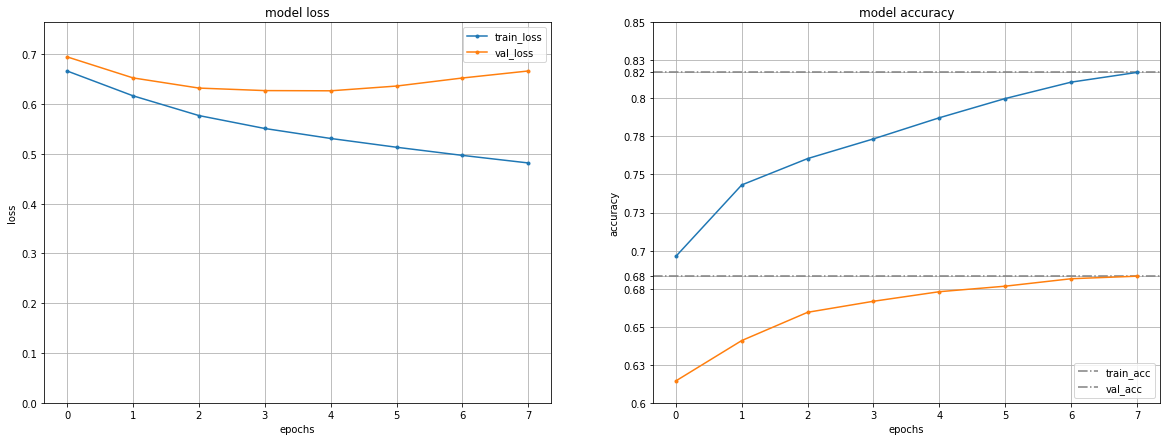

In [ ]:
print_plots(metrics_MRNN_Concat_cs)

In [ ]:
model_MRNN_Sum_cs, metrics_MRNN_Sum_cs = train_loop(
           lambda **pp:  MRNN(n_output=2, merging_mode = Merg_Mode.SUM, cs=True, **pp).to(DEVICE),
           train_dataloader, 
           val_dataloader, 
           epochs=20,  
           criterion = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(WEIGHTS).to(DEVICE)),
           params = {'hidden': 128, 'LR_Adam': 0.0001},
           scheduler_parr = {'step_size': 8, 'gamma':.1},
           early_stop_patience = 4 ,
           verbose=True
           )

| epoch   1 |   300/  952 batches | accuracy    0.738| loss 0.69132
| epoch   1 |   600/  952 batches | accuracy    0.360| loss 0.69482
| epoch   1 |   900/  952 batches | accuracy    0.527| loss 0.67739
-------------------------------------------------------------------------------------
  | end of epoch   1 | time: 63.36s | valid accuracy    0.573 | valid loss:   0.697
-------------------------------------------------------------------------------------
| epoch   2 |   300/  952 batches | accuracy    0.723| loss 0.66680
| epoch   2 |   600/  952 batches | accuracy    0.476| loss 0.68016
| epoch   2 |   900/  952 batches | accuracy    0.611| loss 0.64075
-------------------------------------------------------------------------------------
  | end of epoch   2 | time: 64.13s | valid accuracy    0.612 | valid loss:   0.666
-------------------------------------------------------------------------------------
| epoch   3 |   300/  952 batches | accuracy    0.730| loss 0.65096
| epoch   3 

In [ ]:
model_MRNN_Mean_cs, metrics_MRNN_Mean_cs = train_loop(
           lambda **pp:  MRNN(n_output=2, merging_mode = Merg_Mode.MEAN, cs=True, **pp).to(DEVICE),
           train_dataloader, 
           val_dataloader, 
           epochs=20,  
           criterion = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(WEIGHTS).to(DEVICE)),
           params = {'hidden': 128, 'LR_Adam': 0.0001},
           scheduler_parr = {'step_size': 8, 'gamma':.1},
           early_stop_patience = 4 ,
           verbose=True
           )

| epoch   1 |   300/  952 batches | accuracy    0.775| loss 0.69219
| epoch   1 |   600/  952 batches | accuracy    0.357| loss 0.69375
| epoch   1 |   900/  952 batches | accuracy    0.510| loss 0.67662
-------------------------------------------------------------------------------------
  | end of epoch   1 | time: 63.92s | valid accuracy    0.577 | valid loss:   0.698
-------------------------------------------------------------------------------------
| epoch   2 |   300/  952 batches | accuracy    0.726| loss 0.67795
| epoch   2 |   600/  952 batches | accuracy    0.485| loss 0.67357
| epoch   2 |   900/  952 batches | accuracy    0.627| loss 0.62277
-------------------------------------------------------------------------------------
  | end of epoch   2 | time: 64.21s | valid accuracy    0.624 | valid loss:   0.664
-------------------------------------------------------------------------------------
| epoch   3 |   300/  952 batches | accuracy    0.738| loss 0.64200
| epoch   3 

#### Comparison

In [ ]:
print(f"Model: MRNN Concat   | Validation F1-score macro: {metrics_MRNN_Concat_cs['f1_score']}")
print(f"Model: MRNN Sum      | Validation F1-score macro: {metrics_MRNN_Sum_cs['f1_score']}")
print(f"Model: MRNN Mean     | Validation F1-score macro: {metrics_MRNN_Mean_cs['f1_score']}")

Model: MRNN Concat   | Validation F1-score macro: 0.6824458883756165
Model: MRNN Sum      | Validation F1-score macro: 0.6639999672681769
Model: MRNN Mean     | Validation F1-score macro: 0.6736797616310103


### MLP architecture

#### Trainings

In [ ]:
MLP_train_dataloader,MLP_val_dataloader= \
  (DataLoader(_, batch_size=BATCH_SIZE, shuffle=False, collate_fn=Define_padding("global")) for _ in datasets)

In [ ]:
model_MLP_Concat_cs, metrics_MLP_Concat_cs = train_loop(
           lambda **pp:  MLP(n_output=2, merging_mode = Merg_Mode.CONCAT, cs=True, **pp).to(DEVICE),
           MLP_train_dataloader,
           MLP_val_dataloader,
           epochs=15,
           criterion = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(WEIGHTS).to(DEVICE)),
           params = {'hidden': 128, 'LR_Adam': 0.0001}, 
           verbose=True,
           scheduler_parr = {'step_size': 6, 'gamma':.1},
           early_stop_patience = 4
           )

| epoch   1 |   300/  952 batches | accuracy    0.744| loss 0.65976
| epoch   1 |   600/  952 batches | accuracy    0.542| loss 0.62808
| epoch   1 |   900/  952 batches | accuracy    0.643| loss 0.62809
-------------------------------------------------------------------------------------
  | end of epoch   1 | time: 38.51s | valid accuracy    0.601 | valid loss:   0.713
-------------------------------------------------------------------------------------
| epoch   2 |   300/  952 batches | accuracy    0.744| loss 0.59906
| epoch   2 |   600/  952 batches | accuracy    0.625| loss 0.56408
| epoch   2 |   900/  952 batches | accuracy    0.708| loss 0.55394
-------------------------------------------------------------------------------------
  | end of epoch   2 | time: 38.10s | valid accuracy    0.621 | valid loss:   0.737
-------------------------------------------------------------------------------------
| epoch   3 |   300/  952 batches | accuracy    0.769| loss 0.57282
| epoch   3 

In [ ]:
model_MLP_Mean_cs, metrics_MLP_Mean_cs = train_loop(
           lambda **pp:  MLP(n_output=2, merging_mode = Merg_Mode.MEAN, cs=True, **pp).to(DEVICE),
           MLP_train_dataloader,
           MLP_val_dataloader,
           epochs=15,
           criterion = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(WEIGHTS).to(DEVICE)),
           params = {'hidden': 128, 'LR_Adam': 0.0001}, 
           verbose=True,
           scheduler_parr = {'step_size': 6, 'gamma':.1},
           early_stop_patience = 4
           )

| epoch   1 |   300/  952 batches | accuracy    0.750| loss 0.66900
| epoch   1 |   600/  952 batches | accuracy    0.508| loss 0.66043
| epoch   1 |   900/  952 batches | accuracy    0.634| loss 0.61544
-------------------------------------------------------------------------------------
  | end of epoch   1 | time: 42.67s | valid accuracy    0.601 | valid loss:   0.713
-------------------------------------------------------------------------------------
| epoch   2 |   300/  952 batches | accuracy    0.737| loss 0.59804
| epoch   2 |   600/  952 batches | accuracy    0.619| loss 0.58748
| epoch   2 |   900/  952 batches | accuracy    0.701| loss 0.54943
-------------------------------------------------------------------------------------
  | end of epoch   2 | time: 44.91s | valid accuracy    0.618 | valid loss:   0.727
-------------------------------------------------------------------------------------
| epoch   3 |   300/  952 batches | accuracy    0.758| loss 0.58250
| epoch   3 

In [ ]:
model_MLP_Sum_cs, metrics_MLP_Sum_cs = train_loop(
           lambda **pp:  MLP(n_output=2, merging_mode = Merg_Mode.SUM, cs=True, **pp).to(DEVICE),
           MLP_train_dataloader,
           MLP_val_dataloader,
           epochs=15,
           criterion = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(WEIGHTS).to(DEVICE)),
           params = {'hidden': 128, 'LR_Adam': 0.0001}, 
           verbose=True,
           scheduler_parr = {'step_size': 6, 'gamma':.1},
           early_stop_patience = 4
           )

| epoch   1 |   300/  952 batches | accuracy    0.740| loss 0.66790
| epoch   1 |   600/  952 batches | accuracy    0.534| loss 0.64691
| epoch   1 |   900/  952 batches | accuracy    0.639| loss 0.61560
-------------------------------------------------------------------------------------
  | end of epoch   1 | time: 38.26s | valid accuracy    0.603 | valid loss:   0.718
-------------------------------------------------------------------------------------
| epoch   2 |   300/  952 batches | accuracy    0.740| loss 0.60793
| epoch   2 |   600/  952 batches | accuracy    0.621| loss 0.57606
| epoch   2 |   900/  952 batches | accuracy    0.702| loss 0.57943
-------------------------------------------------------------------------------------
  | end of epoch   2 | time: 39.78s | valid accuracy    0.624 | valid loss:   0.720
-------------------------------------------------------------------------------------
| epoch   3 |   300/  952 batches | accuracy    0.764| loss 0.57085
| epoch   3 

#### Comparison

In [ ]:
print(f"Model: MLP Concat  | Validation F1-score macro: {metrics_MLP_Concat_cs['f1_score']}")
print(f"Model: MLP Sum     | Validation F1-score macro: {metrics_MLP_Sum_cs['f1_score']}")
print(f"Model: MLP Mean    | Validation F1-score macro: {metrics_MLP_Mean_cs['f1_score']}")

Model: MLP Concat  | Validation F1-score macro: 0.5798268241930213
Model: MLP Sum     | Validation F1-score macro: 0.5943643661071425
Model: MLP Mean    | Validation F1-score macro: 0.644198022380305


### ME architecture

#### Trainings

In [35]:
model_ME_Concat_cs, metrics_ME_Concat_cs = train_loop(
           lambda **pp:  ME(n_output=2, merging_mode = Merg_Mode.CONCAT, cs=True, **pp).to(DEVICE),
           train_dataloader, 
           val_dataloader, 
           epochs=20, 
           criterion = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(WEIGHTS).to(DEVICE)),
           params = {'hidden': 128, 'LR_Adam': 0.0001}, 
           verbose=True,
           scheduler_parr = {'step_size': 6, 'gamma':.1},
           early_stop_patience = 4
           )

| epoch   1 |   300/  952 batches | accuracy    0.770| loss 0.68642
| epoch   1 |   600/  952 batches | accuracy    0.366| loss 0.69342
| epoch   1 |   900/  952 batches | accuracy    0.542| loss 0.66292
-------------------------------------------------------------------------------------
  | end of epoch   1 | time: 23.98s | valid accuracy    0.577 | valid loss:   0.707
-------------------------------------------------------------------------------------
| epoch   2 |   300/  952 batches | accuracy    0.731| loss 0.68008
| epoch   2 |   600/  952 batches | accuracy    0.503| loss 0.66452
| epoch   2 |   900/  952 batches | accuracy    0.617| loss 0.62024
-------------------------------------------------------------------------------------
  | end of epoch   2 | time: 24.67s | valid accuracy    0.627 | valid loss:   0.686
-------------------------------------------------------------------------------------
| epoch   3 |   300/  952 batches | accuracy    0.724| loss 0.66540
| epoch   3 

In [36]:
model_ME_Mean_cs, metrics_ME_Mean_cs = train_loop(
           lambda **pp:  ME(n_output=2, merging_mode = Merg_Mode.MEAN, cs=True, **pp).to(DEVICE),
           train_dataloader, 
           val_dataloader, 
           epochs=20, 
           criterion = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(WEIGHTS).to(DEVICE)),
           params = {'hidden': 128, 'LR_Adam': 0.0001}, 
           verbose=True,
           scheduler_parr = {'step_size': 6, 'gamma':.1},
           early_stop_patience = 4
           )

| epoch   1 |   300/  952 batches | accuracy    0.729| loss 0.68803
| epoch   1 |   600/  952 batches | accuracy    0.375| loss 0.69657
| epoch   1 |   900/  952 batches | accuracy    0.477| loss 0.67924
-------------------------------------------------------------------------------------
  | end of epoch   1 | time: 23.29s | valid accuracy    0.537 | valid loss:   0.705
-------------------------------------------------------------------------------------
| epoch   2 |   300/  952 batches | accuracy    0.752| loss 0.68806
| epoch   2 |   600/  952 batches | accuracy    0.396| loss 0.68789
| epoch   2 |   900/  952 batches | accuracy    0.520| loss 0.66689
-------------------------------------------------------------------------------------
  | end of epoch   2 | time: 23.29s | valid accuracy    0.582 | valid loss:   0.692
-------------------------------------------------------------------------------------
| epoch   3 |   300/  952 batches | accuracy    0.723| loss 0.67918
| epoch   3 

In [37]:
model_ME_Sum_cs, metrics_ME_Sum_cs = train_loop(
           lambda **pp:  ME(n_output=2, merging_mode = Merg_Mode.SUM, cs=True, **pp).to(DEVICE),
           train_dataloader, 
           val_dataloader, 
           epochs=20, 
           criterion = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(WEIGHTS).to(DEVICE)),
           params = {'hidden': 128, 'LR_Adam': 0.0001}, 
           verbose=True,
           scheduler_parr = {'step_size': 6, 'gamma':.1},
           early_stop_patience = 4
           )

| epoch   1 |   300/  952 batches | accuracy    0.762| loss 0.69549
| epoch   1 |   600/  952 batches | accuracy    0.363| loss 0.69095
| epoch   1 |   900/  952 batches | accuracy    0.507| loss 0.68018
-------------------------------------------------------------------------------------
  | end of epoch   1 | time: 23.23s | valid accuracy    0.555 | valid loss:   0.706
-------------------------------------------------------------------------------------
| epoch   2 |   300/  952 batches | accuracy    0.740| loss 0.68484
| epoch   2 |   600/  952 batches | accuracy    0.422| loss 0.68704
| epoch   2 |   900/  952 batches | accuracy    0.559| loss 0.66172
-------------------------------------------------------------------------------------
  | end of epoch   2 | time: 23.28s | valid accuracy    0.593 | valid loss:   0.691
-------------------------------------------------------------------------------------
| epoch   3 |   300/  952 batches | accuracy    0.720| loss 0.67792
| epoch   3 

#### Comparison

In [ ]:
print(f"Model: ME Mean    | Validation F1-score macro: {metrics_ME_Concat_cs['f1_score']}")
print(f"Model: ME Concat  | Validation F1-score macro: {metrics_ME_Sum_cs['f1_score']}")
print(f"Model: ME Sum     | Validation F1-score macro: {metrics_ME_Mean_cs['f1_score']}")

## Evaluation

According to the results that we obtained, and after a comparison made on the validation set, the best model architecture turned out to be the MRNN model with the concatenation merging mode. We apply the final evaluation on this model.

In [88]:
ENCODED_TEST_DF = apply_conversion(TEST_DF, WORD_TO_POSITION_DD)

test_dataloader = DataLoader(
    CustomTextDataset(ENCODED_TEST_DF),
    batch_size=BATCH_SIZE,
    collate_fn=Define_padding()
)

Weights matrix size: (44461, 200)


In [50]:
# We update the embedding matrix with the OOV terms coming from the test set
model_MRNN_Concat_cs.update_embedding(np.concatenate([model_MRNN_Concat_cs.embedding.weight.cpu().detach().numpy(),\
                                          WEIGHT_MATRIX[model_MRNN_Concat_cs.embedding.weight.size(0):,:]]))


### Multi-input classification evaluation

In [51]:
_, test_accuracy, labels_and_pred_accum = evaluate(test_dataloader, model_MRNN_Concat_cs.cuda(), retain=True)

print("Model: MRNN with concatenation merging mode:")
print(f"Test F1-score: {get_f1_score(labels_and_pred_accum)} | Test accuracy: {test_accuracy}")
print(f"Test Precision: {get_precision(labels_and_pred_accum)} | Test recall: {get_recall_score(labels_and_pred_accum)}")


Model: MRNN with concatenation merging mode:
Test F1-score: 0.6601177322315155 | Test accuracy: 0.6630963972736125
Test Precision: 0.6685089812837584 | Test recall: 0.6628036752712669


###  Claim verification evaluation

In [65]:
def Claim_evaluation(dataframe,model,pad=False):
  id_unique,id_index,_=np.unique(dataframe['ID'],return_counts=True,return_index=True)
  model.eval()
  with torch.no_grad():
    total=0 
    predicted=[]
    for i in id_index:
      predictions_same_claim=0
      evidences=dataframe['Evidence'][dataframe['ID']==dataframe['ID'].iloc[i]]
      voted=[]
      for j in evidences:
        accumulated_good_pred, total_count = 0, 0
       
        predicted_label = model( tensor(dataframe['Claim'].iloc[i]).reshape((1,-1)), tensor(j).reshape((1,-1)))
        voted.append(predicted_label.argmax(1).item())
        predictions_same_claim+=(predicted_label.argmax(1)==dataframe['Label'].iloc[i].argmax(0)).sum().item()

      a,b=np.unique(voted,return_counts=True)
      a=a[np.argmax(b)]
      predicted.append(a)

      total+=(predictions_same_claim/len(evidences)>0.5)

    return total/id_unique.shape[0], predicted, dataframe['Label'][id_index].apply(lambda x: x.argmax(0).item())

In [66]:
accuracy,y_pred,y_true=Claim_evaluation(ENCODED_TEST_DF,model_MRNN_Concat_cs.cpu())

In [69]:
print("Model: MRNN with concatenation merging mode:")
print(f"Test F1-score: {f1_score(y_true, y_pred, average='macro')} | Test accuracy: {accuracy}")
print(f"Test Precision: {precision_score(y_true, y_pred, average='macro')} | Test recall: {recall_score(y_true, y_pred, average='macro')}")

Model: MRNN with concatenation merging mode:
Test F1-score: 0.6624353214656651 | Test accuracy: 0.6599122939664298
Test Precision: 0.6706918606465081 | Test recall: 0.6651367939956843


## Error analysis and conclusions

In [89]:
from pprint import pformat, pprint

revert = lambda dict_: { v:k for k,v in dict_.items() }
POSITION_TO_WORD = revert(WORD_TO_POSITION_DD)


In [94]:
num=0
for i in ENCODED_TEST_DF.index:
  predicted_label=model_MRNN_Concat_cs( tensor(ENCODED_TEST_DF['Claim'].iloc[i]).reshape((1,-1)), tensor(ENCODED_TEST_DF['Evidence'].iloc[i]).reshape((1,-1)))
  
  if(predicted_label.argmax(1)!=ENCODED_TEST_DF['Label'].iloc[i].argmax(0)):
    print("CLAIM:")
    print(' '.join([POSITION_TO_WORD[j] for j in ENCODED_TEST_DF['Claim'].iloc[i]])) 
    print("EVIDENCE:")
    print(' '.join([POSITION_TO_WORD[j] for j in ENCODED_TEST_DF['Evidence'].iloc[i]]))
    print("True Prediction:")
    print(ENCODED_TEST_DF['Label'].iloc[i].argmax(0).item())
    print("Predicted:")
    print(predicted_label.argmax(1).item())
    print()
    num+=1
    if(num==15):
      break

CLAIM:
firefox application .
EVIDENCE:
mozilla firefox ( simply firefox ) free open-source web browser developed mozilla foundation subsidiary mozilla corporation . mozilla foundation mozilla foundation mozilla corporation mozilla corporation free open-source free open-source web browser web browser
True Prediction:
1
Predicted:
0

CLAIM:
google search find stock quotes .
EVIDENCE:
these include synonyms , weather forecasts , time zones , stock quotes , maps , earthquake data , movie showtimes , airports , home listings , sports scores .
True Prediction:
1
Predicted:
0

CLAIM:
a good day die hard directed john moore .
EVIDENCE:
the film directed john moore written skip woods , stars bruce willis john mcclane . john moore john moore ( director ) skip woods skip woods bruce willis bruce willis john mcclane john mcclane
True Prediction:
1
Predicted:
0

CLAIM:
spider-man 2 released 2004 .
EVIDENCE:
spider-man 2 2004 american superhero film directed sam raimi written alvin sargent story alf